In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import modules
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import _LRScheduler

from IPython.display import display
from util import *

In [2]:
class inverseNN(nn.Module):
  def __init__(self, size, input_norm):
    super().__init__()
    self.inverse = nn.Linear(size, size, bias=False) # x@A.T
    with torch.no_grad():
      weight_init = torch.randn(size, size)
      weight_norm = torch.norm(weight_init)
      weight_init /= (weight_norm * input_norm)
      self.inverse.weight.data = weight_init
  
  def forward(self, x):
    return self.inverse(x)

In [3]:
class CustomLRScheduler(_LRScheduler):
  def __init__(self, optimizer, thresholds, lr, last_epoch=-1):
    """
    thresholds and lr are both arrays
    The length of thresholds must be 1 less than that of lr
    """
    self.thresholds = thresholds
    self.lr = lr
    super().__init__(optimizer, last_epoch)

  def get_lr(self):
    for i, threshold in enumerate(self.thresholds):
       if self.last_epoch < threshold:
          return [self.lr[i] for _ in self.optimizer.param_groups]
    return [self.lr[-1] for _ in self.optimizer.param_groups]

In [4]:
def fitting(size, input, lr, num_epochs, report_interval, inverse_gt, optimizer=True):
  '''
  size (int): the size of the input matrix
  input (np.ndarray): numpy matrix to be inverted of shape (size, size)
  '''

  # initialize fitter
  input = torch.tensor(input, dtype=torch.float32)
  target = torch.tensor(np.eye(size), dtype=torch.float32)
  input_norm = torch.norm(input)
  fitter = inverseNN(size, input_norm)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(fitter.parameters(), lr=lr)
  scheduler = CustomLRScheduler(optimizer, thresholds=[10e3, 100e3, 1e6], lr=[0.05, 0.025, 0.01, 0.005])

  # ground truth inverse
  inverse_gt = torch.tensor(inverse_gt, dtype=torch.float32).cuda()
  inverse_gt_t = torch.transpose(inverse_gt, 1, 0).cuda()

  # logging
  epoch_log = np.zeros(int(num_epochs//report_interval))
  loss_log = np.zeros(int(num_epochs//report_interval))
  aux_loss_log = np.zeros(int(num_epochs//report_interval))

  # fitting
  input = input.cuda()
  target = target.cuda()
  input_norm = input_norm.cuda()
  fitter = fitter.cuda()
  
  for epoch in range (num_epochs):
    output = fitter(input)
    loss = criterion(output, target)
    loss.backward()
    if (optimizer):
      optimizer.step()
      scheduler.step()
      optimizer.zero_grad()
    else:
      with torch.no_grad():
        for param in fitter.parameters():
            param -= lr * param.grad
      fitter.zero_grad()

    # log result
    if (epoch+1) % (report_interval) == 0:
      inverse_fit_t = fitter.inverse.weight.data
      aux_loss = criterion(inverse_fit_t, inverse_gt_t)
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}, Aux loss: {aux_loss.item():.8f}')
      print(f'Learning rate: {scheduler.get_last_lr()[0]:.6f}')
      index = (epoch+1)//report_interval - 1
      epoch_log[index] = epoch+1
      loss_log[index] = loss.item()
      aux_loss_log[index] = aux_loss.item()
    
  inverse_fit = torch.transpose(fitter.inverse.weight.data.cpu(), 0, 1).numpy()
  return inverse_fit, epoch_log, loss_log, aux_loss_log

In [29]:
size = 16
num_epochs = int(1e6)
lr = 0.05
report_interval = int(10e3)
matrix = generate_non_singular_matrix_qr(size)
inverse_gt = np.linalg.inv(matrix)

In [30]:
inverse_fit_ADAM, epoch_log_ADAM, loss_log_ADAM, aux_loss_log_ADAM = fitting(size, matrix, lr, num_epochs, report_interval, inverse_gt, optimizer=True)

Epoch [10000/1000000], Loss: 0.00188580, Aux loss: 212.32678223
Learning rate: 0.025000
Epoch [20000/1000000], Loss: 0.00091610, Aux loss: 101.05329895
Learning rate: 0.025000
Epoch [30000/1000000], Loss: 0.00042955, Aux loss: 46.62932587
Learning rate: 0.025000
Epoch [40000/1000000], Loss: 0.00022234, Aux loss: 21.50585556
Learning rate: 0.025000
Epoch [50000/1000000], Loss: 0.00009571, Aux loss: 9.90933037
Learning rate: 0.025000
Epoch [60000/1000000], Loss: 0.00004212, Aux loss: 4.56545067
Learning rate: 0.025000
Epoch [70000/1000000], Loss: 0.00002687, Aux loss: 2.10268831
Learning rate: 0.025000
Epoch [80000/1000000], Loss: 0.00002280, Aux loss: 0.96839726
Learning rate: 0.025000
Epoch [90000/1000000], Loss: 0.00004764, Aux loss: 0.44587451
Learning rate: 0.025000
Epoch [100000/1000000], Loss: 0.00000860, Aux loss: 0.20531884
Learning rate: 0.010000
Epoch [110000/1000000], Loss: 0.00000420, Aux loss: 0.09913188
Learning rate: 0.010000
Epoch [120000/1000000], Loss: 0.00000309, Aux 

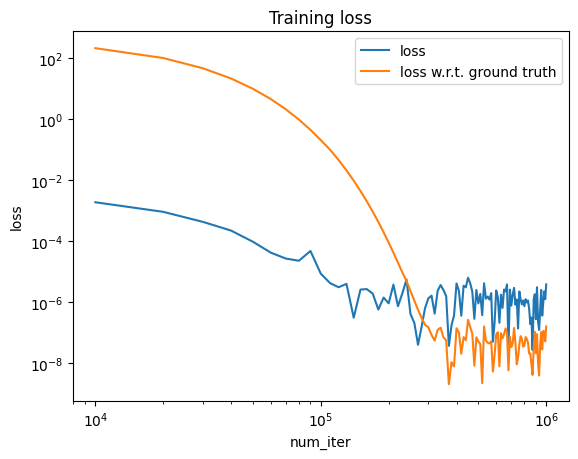

In [32]:
plt.loglog(epoch_log_ADAM, loss_log_ADAM, label='loss')
plt.loglog(epoch_log_ADAM, aux_loss_log_ADAM, label='loss w.r.t. ground truth')
plt.title('Training loss')
plt.xlabel('num_iter')
plt.ylabel('loss')
plt.legend()
plt.savefig(f"torch training loss good (1M).png")
plt.show()

In [33]:
res_fit = pd.DataFrame(np.round(matrix@inverse_fit_ADAM, decimals=3))
display(res_fit)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000,0.0,-0.000,-0.0,0.000,-0.0,-0.0,0.0,-0.0,0.000,-0.0,0.002,0.0,-0.002,-0.0,-0.0
1,-0.001,1.0,0.000,0.0,-0.001,0.0,0.0,-0.0,0.0,-0.000,0.0,-0.004,-0.0,0.004,0.0,0.0
2,-0.001,-0.0,1.000,0.0,-0.001,0.0,0.0,-0.0,0.0,-0.000,0.0,-0.005,-0.0,0.005,0.0,0.0
3,-0.002,-0.0,0.001,1.0,-0.002,0.0,0.0,-0.0,0.0,-0.001,0.0,-0.010,-0.0,0.011,0.0,0.0
4,-0.002,-0.0,0.001,0.0,0.998,0.0,0.0,-0.0,0.0,-0.001,0.0,-0.011,-0.0,0.012,0.0,0.0
5,-0.001,-0.0,0.000,0.0,-0.001,1.0,0.0,-0.0,0.0,-0.000,0.0,-0.004,-0.0,0.004,0.0,0.0
6,-0.002,-0.0,0.001,0.0,-0.002,0.0,1.0,-0.0,0.0,-0.001,0.0,-0.010,-0.0,0.010,0.0,0.0
7,-0.001,-0.0,0.000,0.0,-0.001,0.0,0.0,1.0,0.0,-0.000,0.0,-0.007,-0.0,0.007,0.0,0.0
8,0.001,0.0,-0.000,-0.0,0.001,-0.0,-0.0,0.0,1.0,0.000,-0.0,0.004,0.0,-0.004,-0.0,-0.0
9,0.000,0.0,-0.000,-0.0,0.000,-0.0,-0.0,0.0,-0.0,1.000,-0.0,0.001,0.0,-0.001,-0.0,-0.0


In [34]:
res_gt = pd.DataFrame(np.round(matrix@inverse_gt, decimals=3))
display(res_gt)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0
1,-0.0,1.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0
2,-0.0,0.0,1.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0
3,-0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0
4,0.0,-0.0,-0.0,-0.0,1.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0
5,0.0,-0.0,0.0,0.0,-0.0,1.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0
6,0.0,-0.0,0.0,-0.0,0.0,-0.0,1.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
7,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,1.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0
8,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0
9,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0


In [35]:
diff = pd.DataFrame(np.round(inverse_fit_ADAM-inverse_gt, decimals=3))
display(diff)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.001,-0.0,-0.001,-0.0,-0.0
1,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.001,0.0,-0.001,0.0,0.0
2,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.001,-0.0,-0.001,-0.0,-0.0
3,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.001,-0.0,-0.001,-0.0,-0.0
4,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.001,0.0,-0.001,0.0,0.0
5,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.001,-0.0,-0.001,-0.0,-0.0
6,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.001,0.0,-0.001,0.0,-0.0
7,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.001,0.0,-0.001,0.0,-0.0
8,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.001,0.0,-0.001,-0.0,-0.0
9,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.001,-0.0,-0.001,-0.0,-0.0
